##회귀 실습-자전거 대여 수요 예측

In [74]:
import os
os.chdir("/content/drive/MyDrive/ESAA/회귀")
os.getcwd()

'/content/drive/MyDrive/ESAA/회귀'

bike_train.csv 는 2011년 1월부터 2012년 12월까지 날짜/시간,기온, 습도, 풍속 등의 정보를 기반으로 1시간 간격 동안의 자전거 대여 횟수가 기재되어 있다.

###데이터 클렌징 및 가공  
데이터 세트를 이용해 모델을 학습한 후 대여 횟수(count)를 예측해보자

In [75]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)

bike_df = pd.read_csv("bike_train.csv")
print(bike_df.shape)

(10886, 12)


10886개의 레코드와 12개의 칼럼

In [76]:
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [77]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


Null 데이터는 없으며, 대부분의 칼럼이 int 또는 float 숫자형인데, datetime 칼럼만 object 형이다. Datetime 칼럼의 경우, 년-월-일 시:분:초 문자 형식으로 되어 있으므로 datetime을 년,월,일 그리고 시간과 같이 4개의 속성으로 분리한다.그러기 위해 먼저 문자열을 'datetime' 타입으로 변경하자

In [78]:
#문자열을 datetime 타입으로 변경
bike_df['datetime']=bike_df.datetime.apply(pd.to_datetime)

#datetime 타입에서 년,월,일,시간 추출
bike_df['year']=bike_df.datetime.apply(lambda x :x.year)
bike_df['month']=bike_df.datetime.apply(lambda x :x.month)
bike_df['day']=bike_df.datetime.apply(lambda x :x.day)
bike_df['hour']=bike_df.datetime.apply(lambda x :x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


casual 칼럼 : 사전에 등록하지 않은 사용자의 자전거 대여 횟수  
registered 칼럼 : 사전에 등록한 사용자의 대여 횟수  
casual + registered = count 이므로 casual과 registered가 따로 필요하지는 않다. 오히려 상관도가 높아 예측을 저해할 우려가 있으므로 이 두 칼럼도 삭제하겠다.

In [79]:
drop_columns = ['datetime','casual','registered']
bike_df.drop(drop_columns,axis=1,inplace=True)

In [80]:
bike_df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,1,4


성능 평가 방법: RMSLE(오류 값의 로그에 대한 RMSE)  
어떤 양( log(XX) )의 각각을 제곱(square)한 값을 평균(mean)을 내서, 루트(root)를 씌운다

In [81]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

#log 값 변화 시 NaN 등의 이슈로 log()가 아닌 lop1p()를 이용해 RMSLE 계산
def rmsle(y,pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred)**2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

#사이킷런의 mean_squared_error()를 이용해 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

#MSE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    #MAE는 사이킷런의 mean_absolute_error()로 계산
    mae_val = mean_absolute_error(y,pred)
    print("RMSLE: {0:.3F}, RMSE: {1:.3F}, MAE: {2:.3F}".format(rmsle_val,rmse_val,mae_val))


rmsle() 함수를 만들 때 주의점  
넘파이의 log() 함수를 이용하거나 mean_squared_log_error()를 이용할 수도 있지만 데이터 값의 크기에 따라 오버플로/언더플로 오류가 발생하기 쉽다.  
np.log1p()인 이유  
값이 -inf⇒ 으로 바뀌게 된다. 마찬가지의 방법으로 np.log(1+값)을 해주면 np.log1p()와 같은 값을 얻을 수 있다. np.log1p()로 변환된 값은 다시 넘파이의 expm1()함수로 쉽게 원래의 스케일로 복원될 수 있다.

###로그 변환, 피처 인코딩과 모델 학습/예측/평가

####회귀 모델 적용하기 전 데이터 세트에 대해 먼저 처리해야 할 사항  
1. 결과값이 정규분포로 되어 있는지 확인  
2. 카테고리형 회귀 모델의 경우, 원-핫 인코딩으로 피처를 인코딩

In [82]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis=1, inplace=False)

X_train,X_test,y_train,y_test = train_test_split(X_features,y_target,test_size=0.3,random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test,pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


In [83]:
y_target.head()

0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

In [84]:
y_test.values

array([244, 239, 229, ...,  74,  62, 172])

In [85]:
X_features.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,2011,1,1,4


RMSLE: 1.165, RMSE: 140.900, MAE: 105.924  
실제 Target 데이터 값인 대여 횟수(count)를 감안하면 예측 오류로서는 비교적 큰값이다. 실제 값과 예측값이 어느 정도 차이가 나는지 DataFrame의 칼럼으로 만들어서 오류 값이 가장 큰 순으로 5개만 확인해보자

In [86]:
def get_top_error_data(y_test,pred,n_tops=5):
    #DataFrame의 칼럼으로 실제 대여 횟수(count)와 예측값을 서로 비교할 수 있도록 생성
    result_df = pd.DataFrame(y_test.values,columns=['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count']-result_df['predicted_count'])

    #예측값과 실제값이 가장 큰 
    print(result_df.sort_values(by=['diff'],ascending=False)[:n_tops])

get_top_error_data(y_test,pred,n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


회귀에서 큰 예측 오류가 발생할 경우 가장 먼저 살펴볼 것은 Target값의 분포가 왜곡된 형태를 이루고 있는지 확인하는 것이다. Target 값의 분포는 정규 분포 형태가 가장 좋다.

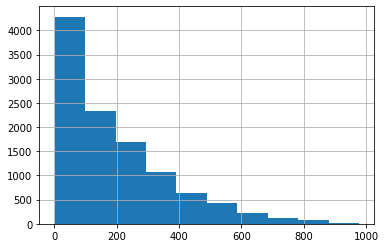

In [87]:
y_target.hist()

count 칼럼 값이 정규 분포가 아닌 0~200 사이에 왜곡되어 있는 것을 알 수 있다. 이렇게 왜곡된 값을 정규분포로 형태로 바꾸는 가장 일반적인 방법은 로그를 적용해 변환하는 것.

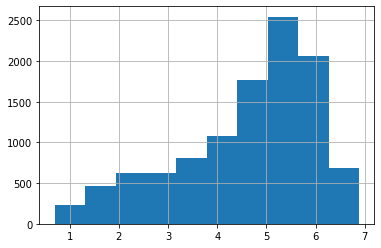

In [88]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

로그로 Target 값을 변환한 후에는 원하는 정규 분포형태는 아니지만 변환하기 전보다는 왜곡 정도가 많이 향상되었다. 이를 이용해 다시 학습한 후 평가를 수행해보자

In [89]:
#타깃 칼럼인 count 값은 log1p로 로그 변환
y_target_log = np.log1p(y_target)

#로그 변환된 y_target_log를 반영해 학습/테스트 데이터 세트 분할
X_train,X_test,y_train,y_test = train_test_split(X_features,y_target_log,test_size=0.3,random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)
pred = lr_reg.predict(X_test)

#테스트 데이터 세트의 Target 값은 로그 변환됐으므로 다시 expm1을 이용해 원래 스케일로 변환
y_test_exp = np.expm1(y_test)

#예측값 역시 로그 변환된 타깃 기반으로 학습돼 예측됐으므로 다시 expm1로 스케일 변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp,pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


RMSLE: 1.017, RMSE: 162.594, MAE: 109.286  
RMSLE 오류는 줄어들었지만, RMSE는 오히려 더 늘어났다.

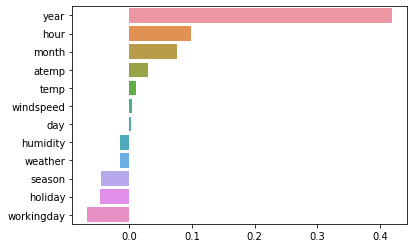

In [90]:
#각 피처의 회귀 계수 값을 시각화해보자
coef= pd.Series(lr_reg.coef_,index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values,y=coef_sort.index)

In [91]:
coef_sort

year          0.418513
hour          0.098348
month         0.076839
atemp         0.030857
temp          0.011712
windspeed     0.003961
day           0.003353
humidity     -0.014512
weather      -0.014733
season       -0.044525
holiday      -0.046010
workingday   -0.066383
dtype: float64

year 피처의 회귀 계수 값이 독보적으로 큰 값을 가지고 있다. year는 2011년,2012년 두 개의 값으로 되어 있다. year에 따라서 자전거 대여 횟수가 크게 영향을 받는다는 것을 납득하기 어렵다. 그 이유는?  
year 피처는 연도를 뜻하므로 카테고리형 피처지만, 숫자형 값으로 되어 있다. 심지어 아주 큰 값인 2011,2012로 되어 있다.  
사이킷런은 카테고리만을 위한 데이터 타입이 없으며, 모두 숫자로 변환해야 함. 이처럼 숫자형 카테고리 값을 선형 회귀에 사용할 경우 회귀 계수를 연산할 때, 이 숫자형 값에 크게 영향을 받는 경우가 발생할 수 있다. 따라서 선형 회귀에서는 이러한 피처 인코딩에 원-핫 인코딩을 적용해 변환해야 한다.

In [92]:
X_features.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,2011,1,1,4


In [93]:
X_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   year        10886 non-null  int64  
 9   month       10886 non-null  int64  
 10  day         10886 non-null  int64  
 11  hour        10886 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 1020.7 KB


In [94]:
#'year','month','day','hour' 등의 피처를 One-Hot Encoding
X_features_ohe = pd.get_dummies(X_features,columns=['year','month','day','hour',
                                                    'holiday','workingday','season','weather'])


In [95]:
X_features_ohe.head()

,temp,atemp,humidity,windspeed,year_2011,year_2012,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,holiday_0,holiday_1,workingday_0,workingday_1,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,9.84,14.395,81,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0
1,9.02,13.635,80,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0
2,9.02,13.635,80,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0
3,9.84,14.395,75,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0
4,9.84,14.395,75,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0


사이킷런의 선형 회귀 모델인 LinearRegression, Ridge, Lasso 모두 학습해 예측 성능을 확인해보자  
get_model_predict()함수  
: 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환해줌 

In [106]:
#원-핫 인코딩이 적용된 피처 데이터 세트 기반으로 학습/예측 데이터 분할
X_train,X_test,y_train,y_test = train_test_split(X_features_ohe,y_target_log,
                                                 test_size=0.3,random_state=0)

#모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환
def get_model_predict(model,X_train,X_test,y_train,y_test,is_expm1=False):
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    if is_expm1:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print("###",model.__class__.__name__,"###")
    evaluate_regr(y_test,pred)
#end of function get_model_predict

#모델별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg,ridge_reg,lasso_reg]:
    get_model_predict(model,X_train,X_test,y_train,y_test,is_expm1=True)

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


In [107]:
X_train.head()

,temp,atemp,humidity,windspeed,year_2011,year_2012,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,holiday_0,holiday_1,workingday_0,workingday_1,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
8620,32.80,37.120,52,11.0014,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0
8985,32.80,35.605,36,0.0000,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0
6171,4.92,6.820,50,12.9980,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0
6473,11.48,13.635,61,15.0013,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,1,0,0,0
10877,17.22,21.210,50,19.0012,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0


원-핫 인코딩을 적용하고 나서 선형 회귀의 예측 성능이 많이 향상되었다.  
원-핫 인코딩된 데이터 세트에서 회귀 계수가 높은 피처를 다시 시각화해보자. 원-핫 인코딩으로 피처가 늘어났으므로 회귀 계수 상위 25개 피처를 추출해보자

In [113]:
coef = pd.Series(lr_reg.coef_,index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:25]

In [114]:
coef_sort

season_4     2.779541e+10
year_2012    1.809949e+10
year_2011    1.809949e+10
month_9      1.655368e+10
month_8      1.655368e+10
month_7      1.655368e+10
season_2     1.225710e+10
season_1     9.844531e+09
holiday_0    1.893416e+09
holiday_1    1.893416e+09
month_3      1.528029e+09
month_2      1.528029e+09
month_1      1.528029e+09
day_17       3.862534e+08
day_19       3.862534e+08
day_15       3.862534e+08
day_11       3.862534e+08
day_13       3.862534e+08
day_5        3.862534e+08
day_18       3.862534e+08
day_14       3.862534e+08
day_10       3.862534e+08
day_4        3.862534e+08
day_16       3.862534e+08
day_2        3.862534e+08
dtype: float64

In [115]:
coef_sort.values

array([2.77954111e+10, 1.80994852e+10, 1.80994852e+10, 1.65536774e+10,
       1.65536774e+10, 1.65536774e+10, 1.22571035e+10, 9.84453059e+09,
       1.89341611e+09, 1.89341611e+09, 1.52802857e+09, 1.52802857e+09,
       1.52802857e+09, 3.86253402e+08, 3.86253402e+08, 3.86253402e+08,
       3.86253402e+08, 3.86253402e+08, 3.86253402e+08, 3.86253402e+08,
       3.86253402e+08, 3.86253402e+08, 3.86253402e+08, 3.86253402e+08,
       3.86253402e+08])

In [116]:
coef_sort.index

Index(['season_4', 'year_2012', 'year_2011', 'month_9', 'month_8', 'month_7',
       'season_2', 'season_1', 'holiday_0', 'holiday_1', 'month_3', 'month_2',
       'month_1', 'day_17', 'day_19', 'day_15', 'day_11', 'day_13', 'day_5',
       'day_18', 'day_14', 'day_10', 'day_4', 'day_16', 'day_2'],
      dtype='object')

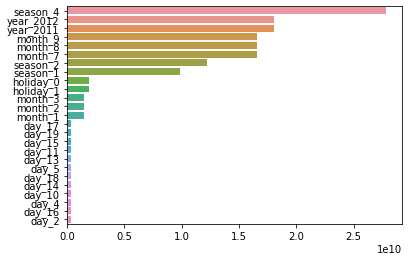

In [117]:
sns.barplot(x=coef_sort.values,y=coef_sort.index)

회귀트리를 이용해 회귀 예측을 수행해보자.  
XGBoost의 경우 DataFrame이 학습/테스트 데이터로 입력될 경우 버전에 따라 오류가 발생할 수 있으므로 학습/테스트 데이터를 DataFrame의 values의 속성을 이용해 넘파이 ndarray로 변환하자.

In [118]:
X_train.values

array([[32.8  , 37.12 , 52.   , ...,  0.   ,  0.   ,  0.   ],
       [32.8  , 35.605, 36.   , ...,  0.   ,  0.   ,  0.   ],
       [ 4.92 ,  6.82 , 50.   , ...,  0.   ,  0.   ,  0.   ],
       ...,
       [27.06 , 31.06 , 39.   , ...,  0.   ,  0.   ,  0.   ],
       [14.76 , 17.425, 87.   , ...,  1.   ,  0.   ,  0.   ],
       [33.62 , 35.605, 30.   , ...,  0.   ,  0.   ,  0.   ]])

In [120]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

#랜덤 포레스트, GBM, XGBoost, LightGBM model별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg,gbm_reg,xgb_reg,lgbm_reg]:
    #XGBoost의 경우 DataFrame이 입력될 경우 버전에 따라 오류 발생 가능, ndarray로 변환
    get_model_predict(model,X_train.values,X_test.values,y_train.values,
                      y_test.values,is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.355, RMSE: 50.362, MAE: 31.138
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.344, MAE: 32.743
[03:53:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
### XGBRegressor ###
RMSLE: 0.345, RMSE: 58.245, MAE: 35.768
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029


앞의 선형 회귀 모델보다 회귀 예측 성능이 개선되었다. 하지만 이것이 회귀 트리가 선형 회귀보다 더 나은 성능을 가진다는 의마는 아니다. 데이터 세트의 유형에 따라 결과는 얼마든지 달라질 수 있다.